In [1]:
%matplotlib inline
import time
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import math
import pulp
import numpy as np
from pprint import pprint
import pandas as pd
import datetime
from scipy import optimize
from scipy.ndimage.filters import maximum_filter

Saved as Example/single image example_result.jpg
Counting Result (λ=30):  22


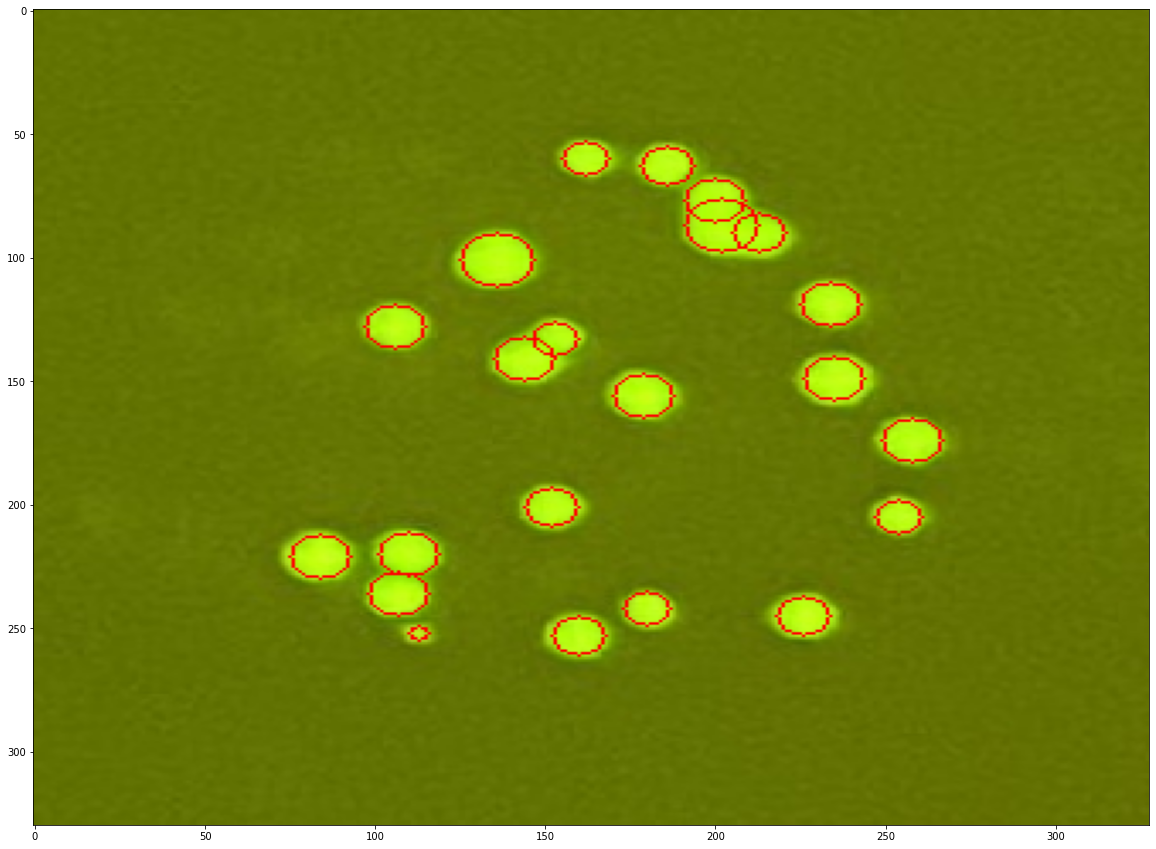

In [2]:
filename = 'Example/single image example.jpg'
destination_filename = 'Example/single image example_result.jpg'
lam = 30           # Hyperparameter: Lambda
d_t = 0.5          # Hyperparameter: d

# Find the first type of candidate circle via local maxima
def find_maxima(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    sub_opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=2)
    dist = cv2.distanceTransform(sub_opening, cv2.DIST_L2, 3)
    
    maxima = (dist > 0) * (dist == maximum_filter(dist, 3, mode='constant', cval=math.inf))
    res = np.where(1 == maxima)
    
    centroids = list(map(list, zip(list(res[1]), list(res[0]), list(dist[res]))))
    count = len(centroids)
    m = maxima
    return count, m, centroids, dist

# Define the distance from Point j to Line jk
def distance(cnt_i, cnt_j, cnt_k):
    x1, y1 = cnt_i[0][0], cnt_i[0][1]
    line_start_x, line_start_y = cnt_j[0][0], cnt_j[0][1]
    x2, y2 = cnt_k[0][0], cnt_k[0][1]
    array_longi = np.array([x2-x1, y2-y1])
    array_trans = np.array([x2-line_start_x, y2-line_start_y])
    array_temp = (float(array_trans.dot(array_longi)) / array_longi.dot(array_longi))
    array_temp = array_longi.dot(array_temp)
    return np.sqrt((array_trans - array_temp).dot(array_trans - array_temp))

def clockwise_angle(v1, v2):
    x1, y1 = v1
    x2, y2 = v2
    dot = x1*x2+y1*y2
    det = x1*y2-x2*y1
    theta = np.arctan2(det, dot)
    return theta

# Calculate the distance of each 2D points from the center (xc, yc)
def calc_R(x,y, xc, yc):
    return np.sqrt((x-xc)**2 + (y-yc)**2)

# Calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc)
def f(c, x, y):
    Ri = calc_R(x, y, *c)
    return Ri - Ri.mean()

# Find the second type of candidate circle via least square fitting
def leastsq_circle(x,y):
    x_m = np.mean(x)
    y_m = np.mean(y)
    center_estimate = x_m, y_m
    center, ier = optimize.leastsq(f, center_estimate, args=(x,y))
    xc, yc = center
    Ri       = calc_R(x, y, *center)
    R        = Ri.mean()
    residu   = np.sum((Ri - R)**2)
    return int(xc), int(yc), R, residu


def seg_counting(labels, xxxxxx, img, lam):
    img_c = np.uint8(255*(labels==xxxxxx))
    count, m, centroids, dist = find_maxima(np.uint8(img_c))
    contours, h = cv2.findContours(img_c,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    contours_split = []
    for cnt in contours:
        turning_points = [cnt[0]]
        i, k = 0, 2
        while k < len(cnt):
            d_max, ind = 0, 0
            for j in range(i+1, k):
                d = distance(cnt[i], cnt[j], cnt[k])
                if d > d_max:
                    d_max = d
                    ind = j
            if d_max > d_t:
                turning_points = np.append(turning_points, [cnt[ind]], axis=0)
                i, k = ind, ind+2
            else:
                k = k + 1

        angles = []
        concave_points = [turning_points[0]]

        for i in range(len(turning_points)-2):
            angles.append(clockwise_angle([turning_points[i+1][0][0]-turning_points[i][0][0], 
                                           turning_points[i+1][0][1]-turning_points[i][0][1]], 
                                          [turning_points[i+2][0][0]-turning_points[i+1][0][0], 
                                           turning_points[i+2][0][1]-turning_points[i+1][0][1]])/math.pi*180)
            if angles[-1] > 0:
                concave_points = np.append(concave_points, [turning_points[i+1]], axis=0)

        index = []
        k = 0

        for i in range(len(cnt)):
            x, y = concave_points[k][0][0], concave_points[k][0][1]
            x_now, y_now = cnt[i][0][0], cnt[i][0][1]
            if x==x_now and y==y_now:
                index.append(i)
                k = k+1
            if k == len(concave_points):
                break

        if contours_split == []:
            contours_split = [[cnt[index[x]:index[x+1]]] for x in range(len(index)-1)]
        else:
            contours_split = contours_split + [[cnt[index[x]:index[x+1]]] for x in range(len(index)-1)]
        contours_split.append([cnt[index[-1]:]])

    for ss in range(len(contours_split)):
        x = [i[0][0] for i in contours_split[ss][0]]
        y = [i[0][1] for i in contours_split[ss][0]]
        if len(x) <= 3:
            continue
        xc, yc, _, _ = leastsq_circle(x,y)
        y_max, x_max = m.shape
        if yc < y_max and yc >= 0 and xc < x_max and xc>= 0:
            if img_c[yc][xc] > 0 and dist[yc][xc] > 0:
                count = count + 1 - int(m[yc][xc])
                m[yc][xc] = 1
                centroids.append((xc, yc, dist[yc][xc]))
        
    # d[i][j] defines the distance from Contour i to Candidate circle j
    d = np.zeros((len(contours_split), count))
    dd = [math.inf for i in contours_split]
    index_d = [-1 for i in contours_split]
    for i in range(len(contours_split)):
        for j in range(count):
            for z in range(len(contours_split[i][0])):
                d[i][j] = d[i][j] + abs(math.dist([contours_split[i][0][z][0][0], contours_split[i][0][z][0][1]], 
                                                  [centroids[j][0], centroids[j][1]]) - centroids[j][2])
            if dd[i] > d[i][j]:
                dd[i] = d[i][j]
                index_d[i] = j
    
    # Solve the optimization problem
    d = np.array(d)
    prob = pulp.LpProblem('contour_mapping', sense=pulp.LpMinimize)
    var_x = [[pulp.LpVariable('x{:5d}{:5d}'.format(i, j), cat=pulp.LpBinary) for j in range(count)]
             for i in range(len(contours_split))]
    flatten = lambda x: [y for l in x for y in flatten(l)] if type(x) is list else [x]
    var_z = [pulp.LpVariable('z{:5d}'.format(j), cat=pulp.LpBinary) for j in range(count)]
    prob += pulp.lpDot(flatten(var_x)+var_z, np.append(d.flatten(), [lam for j in range(count)]))
    for i in range(len(contours_split)):
        prob += (pulp.lpSum(var_x[i]) == 1)
    for j in range(count):
        prob += (pulp.lpSum([var_x[i][j] for i in range(len(contours_split))] + [-var_z[j]]) >= 0)
        prob += (pulp.lpSum([var_x[i][j] for i in range(len(contours_split))] + [-len(contours_split)*var_z[j]]) <= 0)

    # Solver is COIN_CMD
    prob.solve(solver = pulp.getSolver('COIN_CMD'))

    res = {'objective':pulp.value(prob.objective), 
           'var_x': [[pulp.value(var_x[i][j]) for j in range(count)] for i in range(len(contours_split))], 
           'var_z': [pulp.value(var_z[j]) for j in range(count)]}

    final_img = np.uint8(img)
    img_seg = np.uint8(img*np.array([(labels==xxxxxx),(labels==xxxxxx),(labels==xxxxxx)]).transpose(1, 2, 0))
    for i in range(count):
        if res['var_z'][i]:
            img = cv2.circle(final_img, (centroids[i][0], centroids[i][1]), int(centroids[i][2]), (0, 0, 255), 1)
            img_seg = cv2.circle(img_seg, (centroids[i][0], centroids[i][1]), int(centroids[i][2]), (0, 0, 255), 1)
    
    return int(sum(res['var_z'])), final_img, img_seg




img = cv2.imread(filename)
img = img.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh)

counting_result = 0

for xxxxxx in range(1, num_labels):
    counted_cell_number, img, img_seg = seg_counting(labels, xxxxxx, img, lam)
    counting_result = counting_result + counted_cell_number

print("Saved as " + destination_filename)
cv2.imwrite(destination_filename, img)
print("Counting Result (" + chr(955) + "=" + str(lam) + "): ", counting_result)
plt.figure(figsize = (20,15))
plt.imshow(img[...,::-1], aspect = 'auto')
plt.show()